# MrVI Quick Start Tutorial

MrVI (Multi-resolution Variational Inference) is a model for analyzing multi-sample single-cell RNA-seq data. This tutorial will guide you through the main features of MrVI.
MrVI is particularly suited for single-cell RNA sequencing datasets with comparable observations across many samples. By comparable, we mean observations derived from the same tissue or from the same cell line. This ensures that MrVI can provide accurate, single-cell-resolution estimates.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

Seed set to 0


Last run with scvi-tools version: 1.4.2


In [3]:
# import inspect
# print(inspect.getsource(MRVI))

## Preprocessing and model fitting

```{note}
For general pre-processing for various datatypes used by scvi-tools models, see the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#scrna-seq).
```

For this tutorial, we will use a subset of the COVID-19 single-cell RNA dataset from Stephenson et al. 2021 (Nature Medicine, https://doi.org/10.1038/s41591-021-01329-2) for the purpose of demonstrating the functionality of MrVI.
Specifically, this subset includes PBMCs from 16 donors in the Newcastle cohort (one of the sites comprising the dataset), randomly subsetted to 30,000 cells.

In [4]:
adata_path = os.path.join(save_dir.name, "haniffa_tutorial_subset.h5ad")

adata = sc.read(adata_path, backup_url="https://exampledata.scverse.org/scvi-tools/haniffa_tutorial_subset.h5ad")
sc.pp.highly_variable_genes(
    adata, n_top_genes=10000, inplace=True, subset=True, flavor="seurat_v3"
)
adata

  0%|          | 0.00/294M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 30000 × 10000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'age_int'
    var: 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

Before training, we need to specify which covariates in `obs` should be used as target (`sample_key`) and nuisance variables (`batch_key`). 
In this tutorial, we will use donor IDs (`patient_id`) as the target variable, and leave the batch variable empty since the data is already subsetted to the Newcastle cohort (denoted in `Site`).

Otherwise, we will focus on the following `obs` keys for the analysis:
- `initial_clustering`: coarse cell-type annotations from the original study.
- `Status`: whether the donor had COVID-19 or was healthy.
- `Days_from_onset`: how many days it had been since the onset of symptoms before the sample was taken.

We will initialize the MRVI model with its "pytorch" backend. A JAX backend version can be also be used using backend="jax".

In [5]:
sample_key = "patient_id"  # target covariate
# batch_key="Site"  # nuisance variable identifier
MRVI.setup_anndata(adata, sample_key=sample_key, backend="torch")

/tmp/ipykernel_150430/2019538496.py:3: UserWarning: MRVI model is being setup with PyTorch backend
  MRVI.setup_anndata(adata, sample_key=sample_key, backend="torch")


In [6]:
model = MRVI(adata)
model.train(max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/l

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Once trained, we can plot the ELBO of the model to check if the model has converged.

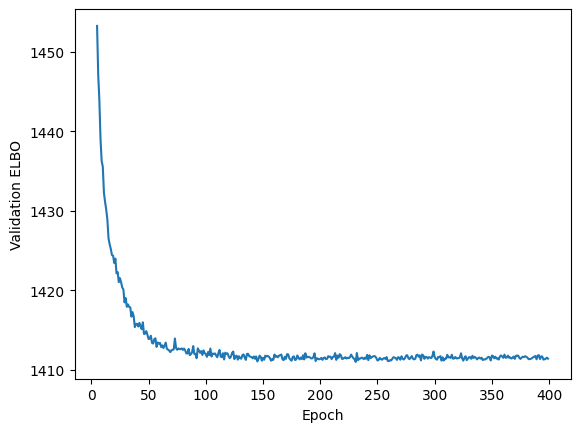

In [7]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

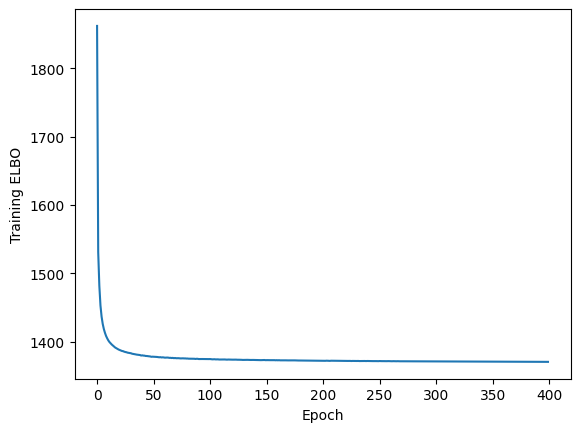

In [8]:
plt.plot(model.history["elbo_train"])
plt.xlabel("Epoch")
plt.ylabel("Training ELBO")
plt.show()

## Visualize cell embeddings and sample distances

The latent representations of the cells can also be accessed and visualized using the `get_latent_representation` method.
MrVI learns two latent representations: `u` and `z`. `u` is designed to capture broad cell states invariant to sample and nuisance covariates, while `z` augments `u` with sample-specific effects but remains corrected for nuisance covariate effects.

In [9]:
u = model.get_latent_representation()
adata.obsm["u"] = u
sc.pp.neighbors(adata, use_rep="u")
sc.tl.umap(adata, min_dist=0.3)

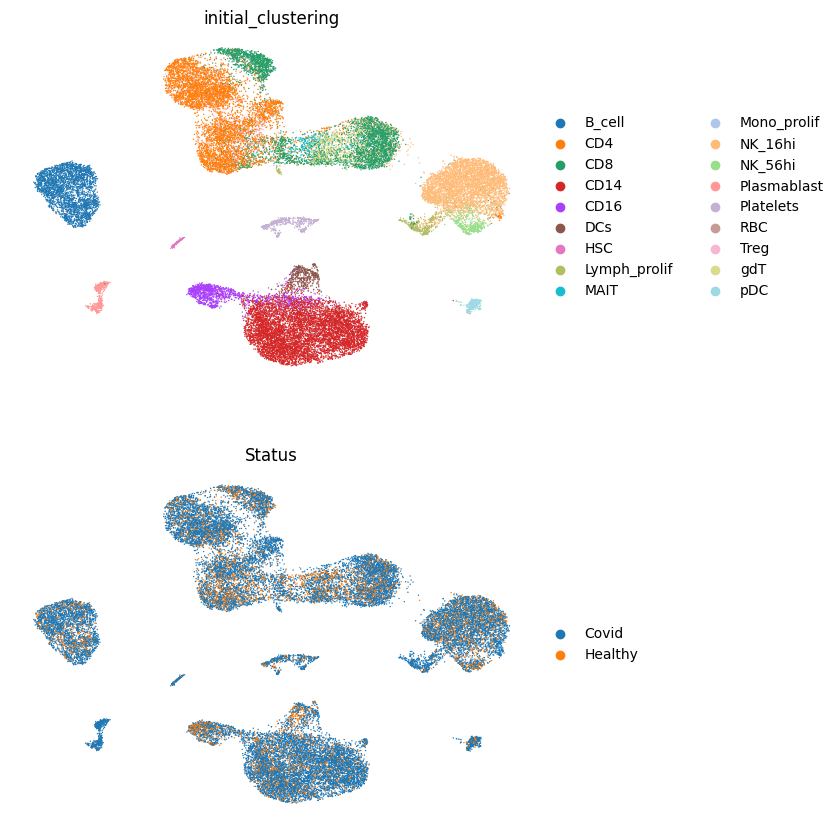

In [10]:
sc.pl.umap(
    adata,
    color=["initial_clustering", "Status"],
    frameon=False,
    ncols=1,
)

Sample distances can be computed using the `get_local_sample_distances` method, which characterizes sample relationships for any cell in the dataset.
This method can return cell-specific distances (`keep_cell=True`), as well as averaged distances within cell subpopulations, characterized by the `groupby` argument.
Specifying `keep_cell=False` will ensure that cell-specific distances are not returned, which can reduce the memory footprint of the returned object in the case where many samples are present.

In [11]:
dists = model.get_local_sample_distances(groupby="initial_clustering")
d1 = dists.loc[{"initial_clustering_name": "CD16"}].initial_clustering

  0%|                                                                                                                     | 0/118 [00:00<?, ?it/s]/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/external/mrvi_torch/_model.py:448: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  cf_sample=torch.Tensor(cf_sample),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 53.79it/s]


In [12]:
dists = model.get_local_sample_distances(groupby="patient_id")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 54.08it/s]


In [13]:
# Avg distance from other samples per cell:
# vector to quantify sample effect heterogeneity within cell populations
cell_dists = dists["cell"]
dist_vec = []
celltype_anno = []
sample_anno = []
target_anno = []

for i in range(cell_dists.shape[0]):
    subannot_temp = adata.obs["patient_id"].iloc[i]
    subannot_temp_index = np.where(cell_dists["sample_x"].to_numpy() == subannot_temp)[0][0]
    vec_temp = cell_dists[i, subannot_temp_index, :].to_numpy()
    dist_vec.append(vec_temp)
    celltype_anno.append([subannot_temp] * len(vec_temp))
    sample_anno.append([adata.obs["patient_id"].iloc[i]] * len(vec_temp))
    target_anno.append(cell_dists[i, :]["sample_y"].values.tolist())

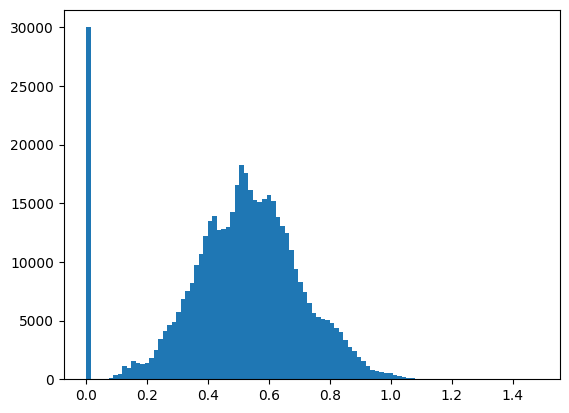

In [14]:
dist_vec = np.concatenate(dist_vec, axis=0)
celltype_anno = np.concatenate(celltype_anno, axis=0)
sample_anno = np.concatenate(sample_anno, axis=0)
target_anno = np.concatenate(target_anno, axis=0)
# Overall distribution of distances
plt.hist(dist_vec, bins=100)
plt.show()

The following cell provides useful utility functions to perform hierarchical clustering based on sample distances, as well as to extract sample metadata of interest to visualize the distance matrices

In [15]:
from matplotlib.colors import to_hex
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform


def get_sample_colors():
    cmap = sns.color_palette("viridis", as_cmap=True)

    def get_onset_colors(x):
        if x == "Healthy":
            return to_hex(np.array([0.5, 0.5, 0.5, 1.0]))
        else:
            x_ = int(x) / 30.0
            return to_hex(cmap(x_))

    covid_map = {
        "Covid": "red",
        "Healthy": "green",
    }
    sample_info = model.sample_info.set_index("sample_id")
    covid_colors = sample_info.Status.map(covid_map).values
    onset_colors = sample_info.Days_from_onset.map(get_onset_colors)
    colors = pd.DataFrame(
        {
            "covid": covid_colors,
            "onset": onset_colors,
        }
    )
    return colors


def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

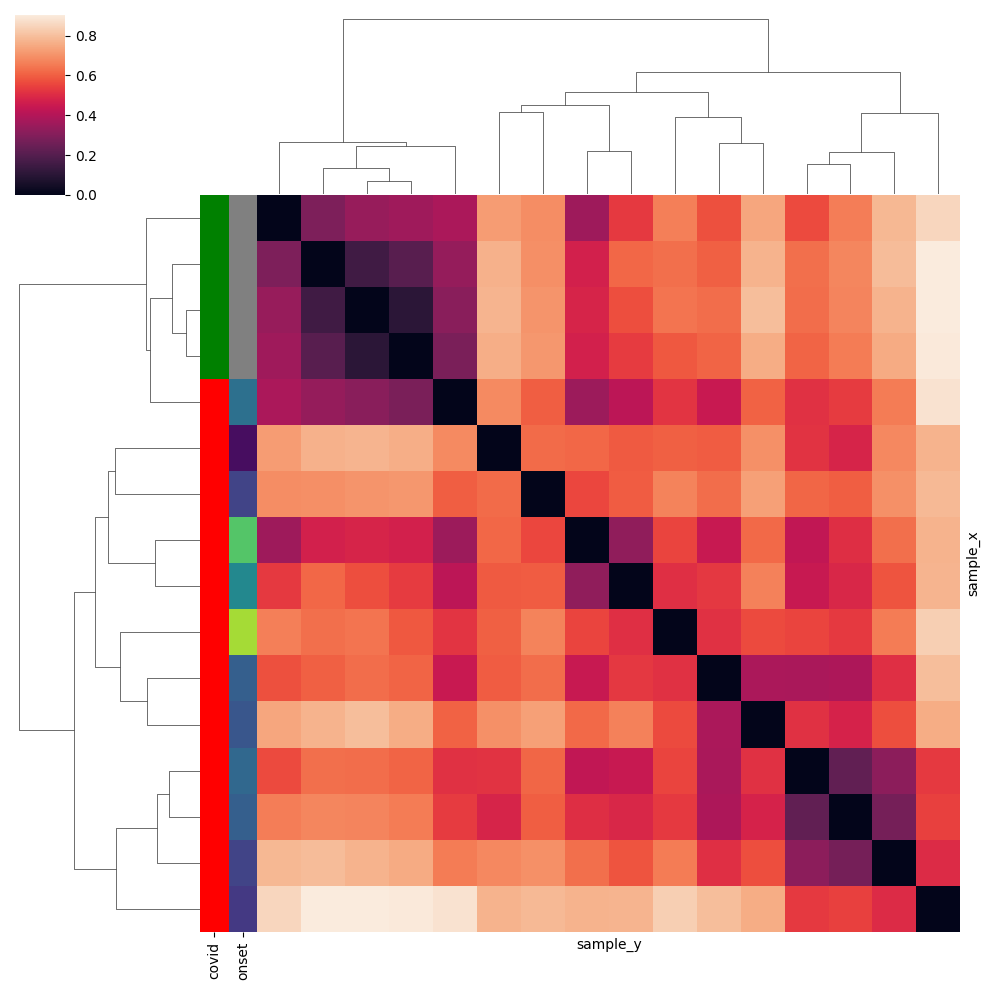

In [16]:
Z = get_dendrogram(d1)
colors = get_sample_colors()

sns.clustermap(
    d1.to_pandas(),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=False,
    row_colors=colors,
)

## Differential expression and differential abundance analysis

In this section of the tutorial, we will explore how to compute differential expression (DE) estimates that are linked to specific covariates of interest at the sample level. For a list of target covariates, MrVI will return covariate-specific effect sizes and p-values for each cell. This allows for a detailed analysis of how different covariates influence gene expression across different cell types. Additionally, you can visualize a summary of the overall effect size of a covariate, which helps in understanding the magnitude of the estimated latent effects of each covariate on the gene expression.

In [17]:
sample_cov_keys = ["Status"]  # Replace with your sample covariate of interest
model.sample_info["Status"] = model.sample_info["Status"].cat.reorder_categories(
    ["Healthy", "Covid"]
)  # Reorder categories such that the coefficient corresponds to Covid
de_res = model.differential_expression(
    sample_cov_keys=sample_cov_keys, store_lfc=True, use_vmap=False
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.61it/s]


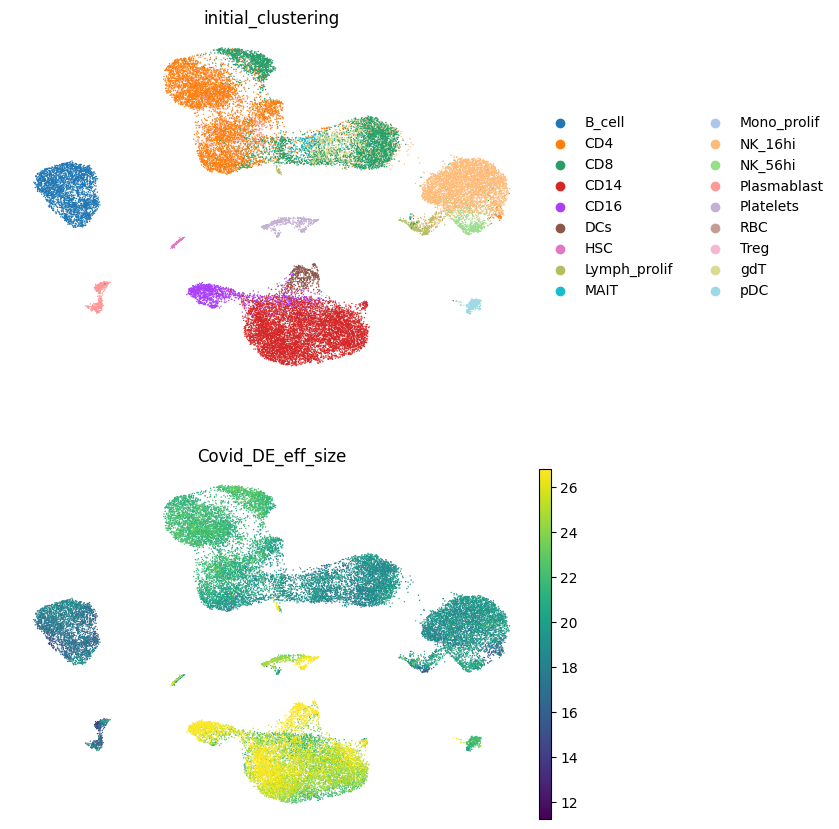

In [18]:
adata.obs["Covid_DE_eff_size"] = de_res.effect_size.sel(covariate="Status_Covid").values
sc.pl.umap(
    adata,
    color=["initial_clustering", "Covid_DE_eff_size"],
    frameon=False,
    ncols=1,
    vmax=np.quantile(de_res.effect_size.values, 0.95),
    cmap="viridis",
)

For the cell types with large effect sizes corresponding to the COVID status, we can look into which genes had the highest average LFCs.

<Figure size 1000x800 with 0 Axes>

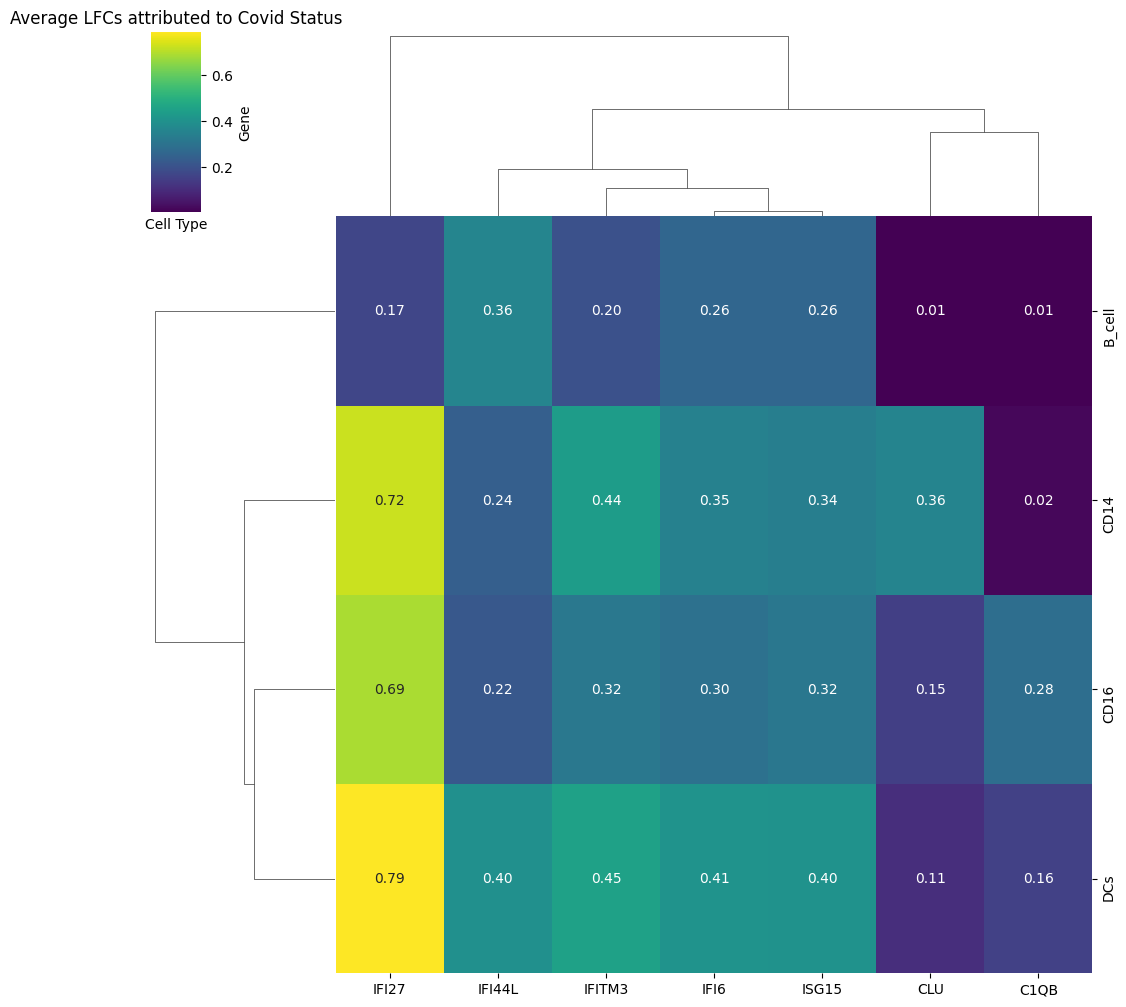

In [19]:
cell_types = ["CD16", "DCs", "CD14"]
top_genes_per_cell_type = {}

for cell_type in cell_types:
    cell_idxs = adata[(adata.obs["initial_clustering"] == cell_type)].obs.index
    top_genes = set(
        de_res.sel(cell_name=cell_idxs, covariate="Status_Covid")
        .mean(dim="cell_name")
        .lfc.to_pandas()
        .abs()
        .nlargest(5)
        .index
    )
    top_genes_per_cell_type[cell_type] = top_genes

all_top_genes = list(set.union(*top_genes_per_cell_type.values()))

# Add B Cells for comparison
cell_types.append("B_cell")

avg_lfcs = []
for cell_type in cell_types:
    cell_idxs = adata[(adata.obs["initial_clustering"] == cell_type)].obs.index
    avg_lfcs.append(
        de_res.sel(cell_name=cell_idxs, gene=all_top_genes).mean(dim="cell_name").lfc.values
    )

heatmap_data = pd.DataFrame(
    np.concatenate(avg_lfcs, axis=0), index=cell_types, columns=all_top_genes
)

plt.figure(figsize=(10, 8))
sns.clustermap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")
plt.title("Average LFCs attributed to Covid Status")
plt.xlabel("Cell Type")
plt.ylabel("Gene")
plt.show()

Next, we will demonstrate how MrVI can be used to estimate local, covariate-linked differential abundance (DA) in single-cell data. Provided with sample-level target covariates, MrVI will return log likelihood values corresponding cell state abundance for each covariate. Differential abundance refers to the change in cellular composition correlated with target covariates, in this case, cellular composition defined over the `u` space.

In [20]:
da_res = model.differential_abundance(sample_cov_keys=sample_cov_keys)
covid_log_probs = da_res.Status_log_probs.loc[{"Status": "Covid"}]
healthy_log_probs = da_res.Status_log_probs.loc[{"Status": "Healthy"}]
covid_healthy_log_prob_ratio = covid_log_probs - healthy_log_probs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.45it/s]


We can take the difference between the log likelihood values to get a log likelihood ratio between two sample covariate groups.
In this case, a positive value corresponds to an enrichment of a certain cell state for donors with COVID.

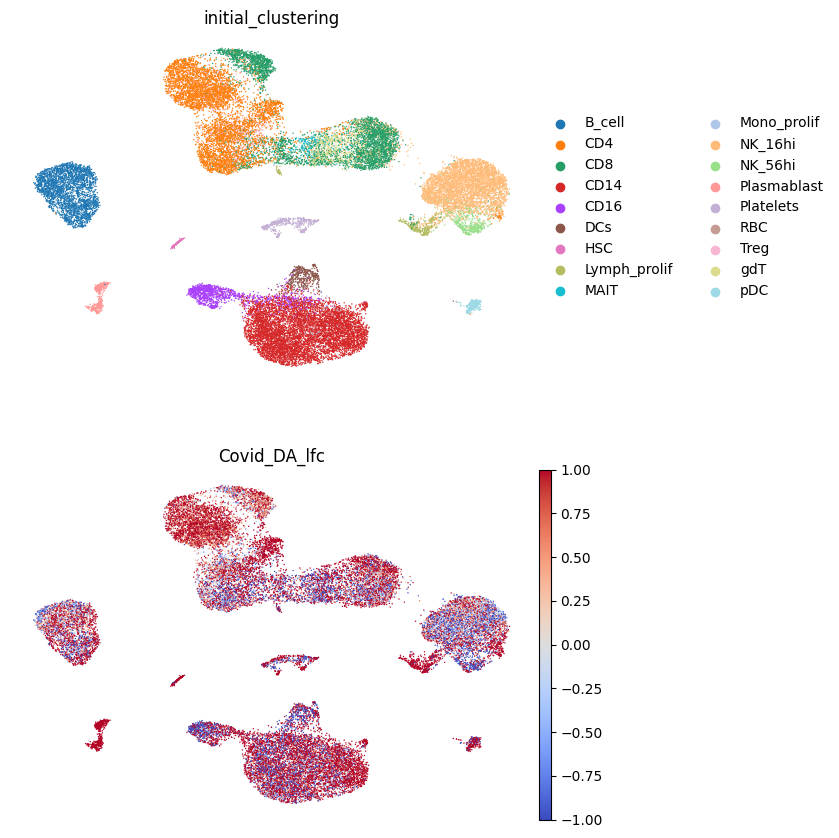

In [21]:
adata.obs["Covid_DA_lfc"] = covid_healthy_log_prob_ratio.values
sc.pl.umap(
    adata,
    color=["initial_clustering", "Covid_DA_lfc"],
    frameon=False,
    ncols=1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    sort_order=False,
)

Finaly, we will show the DA results above displayed as violin plots to demonstrate changes in abundance across cell types. Displayed is the log density ratio between samples from healty and Covid19 patients. We report the significance of the hypothesis that the difference of log density ratios between a given cell type and all other cell types is above 1 in absolute value

In [22]:
cell_types = adata.obs["initial_clustering"].unique()
medians = adata.obs.groupby("initial_clustering")["Covid_DA_lfc"].median()
median_order = medians.sort_values().index.tolist()
star_flags = {ct: (abs(medians[ct]) > 1) for ct in median_order}

/tmp/ipykernel_150430/3922681637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = adata.obs.groupby("initial_clustering")["Covid_DA_lfc"].median()


In [23]:
adata.obs["cell_type_ordered_for_violin"] = pd.Categorical(
    adata.obs["initial_clustering"], categories=median_order, ordered=True
)

/tmp/ipykernel_150430/2953486565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


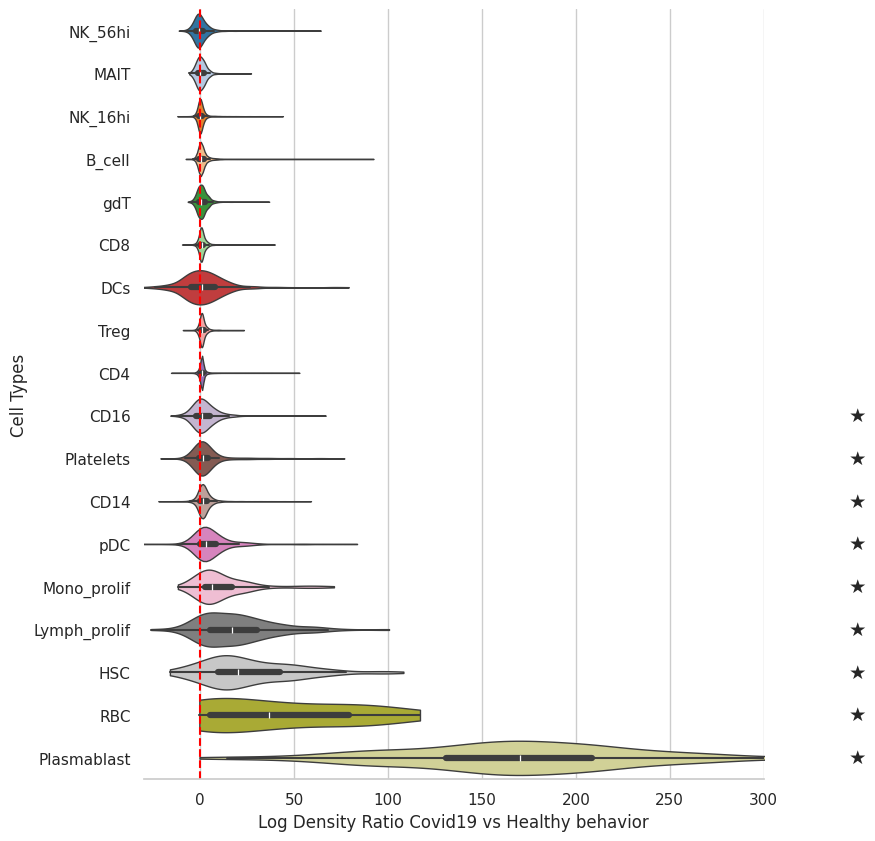

In [24]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 10))
sns.violinplot(
    data=adata.obs,
    y="cell_type_ordered_for_violin",
    x="Covid_DA_lfc",
    hue=None,
    palette="tab20",
    cut=0,
    linewidth=1,
    ax=ax,
)
ax.axvline(0, color="red", linestyle="--", linewidth=1.5)
sns.despine(left=True)
ax.set_ylabel("Cell Types", fontsize=12)
ax.set_xlabel("Log Density Ratio Covid19 vs Healthy behavior", fontsize=12)
ax.set_xlim(-30, 300)
x_pos = np.min([adata.obs["Covid_DA_lfc"].max(), 300]) * 1.15  # slightly beyond max value
for i, ct in enumerate(median_order):
    if star_flags[ct]:
        ax.text(x=x_pos, y=i, s="★", fontsize=14, va="center", ha="left")